In [38]:
import numpy as np
from datasets import load_dataset
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
import string
from typing import List, Tuple, Dict
import re
import nltk
from datasets import Dataset


# Download required NLTK data
def setup_nltk():
    """Download required NLTK resources."""
    try:
        nltk.data.find('taggers/averaged_perceptron_tagger')
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("Downloading required NLTK resources...")
        nltk.download('averaged_perceptron_tagger')
        nltk.download('punkt')

setup_nltk()
from nltk import pos_tag, word_tokenize

def get_pos_tags(sentence: str) -> List[str]:
    """Get POS tags for a sentence using NLTK."""
    if isinstance(sentence, list):
        tokens = sentence
    else:
        tokens = word_tokenize(sentence)
    pos_tagged = pos_tag(tokens)
    return [tag for _, tag in pos_tagged]

def build_pos_tag_dict(dataset) -> Dict[str, int]:
    """Pre-compute POS tag dictionary from the entire dataset."""
    pos_tag_dict = {}
    for split in ['train', 'test', 'validation']:
        for instance in dataset[split]:
            pos_tags = get_pos_tags(instance['tokens'])
            for tag in pos_tags:
                if tag not in pos_tag_dict:
                    pos_tag_dict[tag] = len(pos_tag_dict)
    return pos_tag_dict

def load_and_preprocess_data(dataset_name):
    """Load and preprocess the CoNLL-2003 dataset."""
    dataset = load_dataset(dataset_name, trust_remote_code=True)
    
    X_all = Dataset.from_dict(
        {   
            'id': dataset['train']['id'] + dataset['test']['id'],
            'tokens': dataset['train']['tokens'] + dataset['test']['tokens'],
            'pos_tags': dataset['train']['pos_tags'] + dataset['test']['pos_tags'],
            'chunk_tags': dataset['train']['chunk_tags'] + dataset['test']['chunk_tags'],
            'ner_tags': dataset['train']['ner_tags'] + dataset['test']['ner_tags'],
        }
    )
    dataset['all'] = X_all 
    return dataset

def convert_to_binary_labels(ner_tags: List[int]) -> List[int]:
    """Convert CoNLL-2003 NER tags to binary labels. 1 is for named entities, 0 is for non-named-entities."""
    return [1 if tag != 0 else 0 for tag in ner_tags]

def extract_features_for_token(token: str, tokens: List[str], pos_tags: List[str], 
                             pos_tag_dict: Dict[str, int], index: int, 
                             window_size: int = 2) -> np.ndarray:
    """Extract features for a single token."""
    features = []
    
    # 1. Case-based features (5 features)
    features.extend([
        1.0 if token.isupper() else 0.0,
        1.0 if token.istitle() else 0.0,
        1.0 if token.islower() else 0.0,
        1.0 if any(c.isdigit() for c in token) else 0.0,
        1.0 if re.match(r'.*[A-Z].*[A-Z].*', token) else 0.0  # 2 uppercase letters
    ])
    
    # 2. Token length feature (1 feature)
    features.append(len(token) / 20.0)
    
    # 3. Position-based features (2 features)
    features.extend([
        1.0 if index == 0 else 0.0,
        1.0 if index == len(tokens) - 1 else 0.0
    ])
    
    # 4. Character-based features (4 features)
    features.extend([
        1.0 if '.' in token else 0.0,
        1.0 if ',' in token else 0.0,
        1.0 if '-' in token else 0.0,
        1.0 if "'" in token else 0.0,
        1.0 if "''" in token else 0.0,
        1.0 if "(" in token else 0.0,
        1.0 if ")" in token else 0.0,
        1.0 if any(c in string.punctuation for c in token) else 0.0
    ])
    
    # 5. POS tag feature (one-hot encoded)
    pos_features = np.zeros(len(pos_tag_dict))
    if pos_tags[index] in pos_tag_dict:
        pos_features[pos_tag_dict[pos_tags[index]]] = 1.0
    features.extend(pos_features)
    
    # 6. Context window features
    for i in range(-window_size, window_size + 1):
        if i == 0:
            continue
        pos = index + i
        if pos < 0 or pos >= len(tokens):
            # Padding features for out-of-bounds positions (5 features per position)
            features.extend([0.0] * 5)
        else:
            context_token = tokens[pos]
            features.extend([
                1.0 if context_token.isupper() else 0.0,
                1.0 if context_token.istitle() else 0.0,
                1.0 if context_token.islower() else 0.0,
                len(context_token) / 20.0,
                1.0 if pos_tags[pos] in pos_tag_dict else 0.0
            ])
    
    return np.array(features)

def extract_features_for_sentence(tokens: List[str], pos_tag_dict: Dict[str, int]) -> np.ndarray:
    """Extract features for all tokens in a sentence."""
    pos_tags = get_pos_tags(tokens)
    return np.array([extract_features_for_token(tokens[i], tokens, pos_tags, pos_tag_dict, i) 
                    for i in range(len(tokens))])

def prepare_dataset(dataset_split, pos_tag_dict: Dict[str, int]):
    """Prepare features and labels for a dataset split."""
    all_features = []
    all_labels = []
    
    for instance in dataset_split:
        sentence_features = extract_features_for_sentence(instance['tokens'], pos_tag_dict)
        all_features.extend(sentence_features)
        all_labels.extend(convert_to_binary_labels(instance['ner_tags']))
    
    return np.array(all_features), np.array(all_labels)

def train_and_evaluate():
    """Train SVM model and evaluate its performance."""
    # Load dataset
    dataset = load_and_preprocess_data("eriktks/conll2003")

    # Build POS tag dictionary from entire dataset
    print("Building POS tag dictionary...")
    pos_tag_dict = build_pos_tag_dict(dataset)
    print(f"Number of unique POS tags: {len(pos_tag_dict)}")
    
    # Prepare train and test sets
    print("Preparing training data...")
    X_train, y_train = prepare_dataset(dataset['train'], pos_tag_dict)
    print("Preparing test data...")
    X_test, y_test = prepare_dataset(dataset['all'], pos_tag_dict)
    
    # Scale features
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train SVM
    print("Training SVM model...")
    svm = LinearSVC(random_state=42, max_iter=2000)
    svm.fit(X_train_scaled, y_train)
    
    # Evaluate
    print("Evaluating model...")
    y_pred = svm.predict(X_test_scaled)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, 
                                                             average='binary')
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'model': svm,
        'scaler': scaler,
        'pos_tag_dict': pos_tag_dict
    }

def predict_sentence(sentence: str, svm_model, scaler, pos_tag_dict) -> List[Tuple[str, int]]:
    """Predict NER tags for a new sentence."""
    tokens = word_tokenize(sentence)
    
    # Extract features
    features = extract_features_for_sentence(tokens, pos_tag_dict)
    
    # Scale features
    scaled_features = scaler.transform(features)
    
    # Predict
    predictions = svm_model.predict(scaled_features)
    
    return list(zip(tokens, predictions))


In [39]:
results = train_and_evaluate()

Building POS tag dictionary...
Number of unique POS tags: 43
Preparing training data...
Preparing test data...
Scaling features...
Training SVM model...
Evaluating model...


In [42]:
print(f"Precision: {results['precision']:.2f}")
print(f"Recall: {results['recall']:.2f}")
print(f"F1 Score: {results['f1_score']:.2f}")

Precision: 0.85
Recall: 0.94
F1 Score: 0.90


In [43]:
test_sentence = "Washington DC is the capital of United States of America"
predictions = predict_sentence(
    test_sentence, 
    results['model'], 
    results['scaler'], 
    results['pos_tag_dict']
)
    
formatted_output = " ".join([f"{token}_{pred}" for token, pred in predictions])
print(f"\nInput: {test_sentence}")
print(f"Output: {formatted_output}")


Input: Washington DC is the capital of United States of America
Output: Washington_1 DC_1 is_0 the_0 capital_0 of_0 United_1 States_1 of_0 America_1


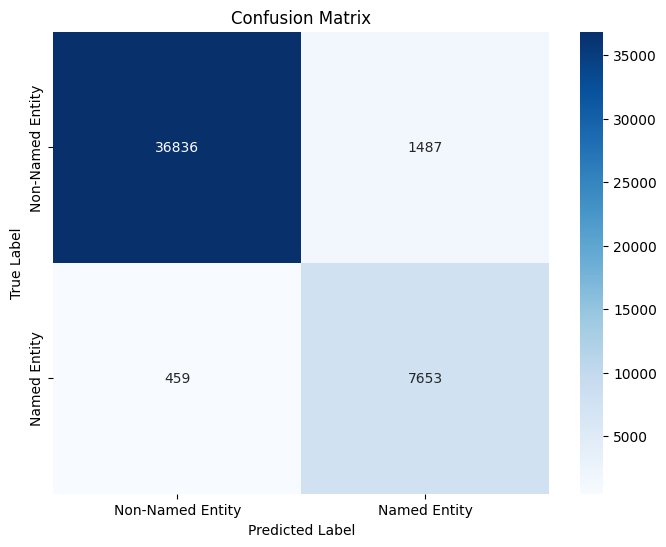

In [11]:
#confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Named Entity', 'Named Entity'],
            yticklabels=['Non-Named Entity', 'Named Entity'])

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
